Balance the dataset

In [88]:

# magic command to reload modules
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import sys
import os
import h5py

NSC_DIR = Path(os.getcwd()).resolve().parent.parent.as_posix()  # NSC dir
sys.path.append(f"{NSC_DIR}/codes/src")
from utils.setup import adapt_path

import matplotlib.pyplot as plt
from tqdm import tqdm   
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


check distribution of the datasets

In [147]:
data_path =f"{NSC_DIR}/data/dataset/dataset-L0-Eset0-100sets-T500.h5"
f = h5py.File(data_path, 'r')

f_feature_path = f'{NSC_DIR}/data/dataset/feature-L0-Eset0-100sets-T500-C100.h5'
f_feature = h5py.File(f_feature_path, 'r')


(0.0, 1.0)

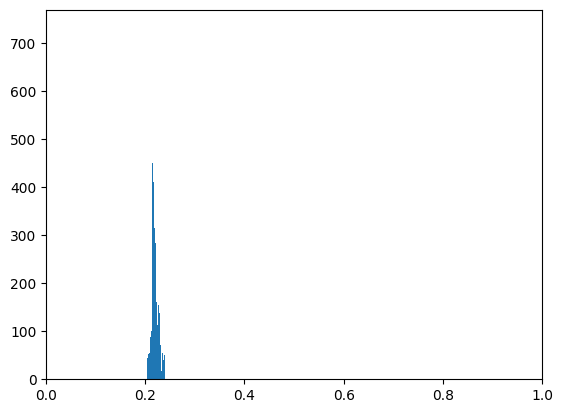

In [148]:
pR = f['set_1']['probR'][:]
_=plt.hist(pR[:,:,:,15].reshape(-1), bins=100)
plt.xlim(0,1)

find with a bin size of 0.1
how many values can be in each bin

In [149]:
n_bins = 20
min_collect = []
for i in tqdm(range(100)):
    pR = f[f'set_{i}']['probR'][:]
    means = [np.mean(pR[:,:,:, i]) for i in range(500)]
    bins = np.histogram(means, bins=n_bins)
    min_collect.append(min(bins[0]))
print('minimum bin number is', min(min_collect))
print(min_collect)

  2%|▏         | 2/100 [00:00<00:05, 17.46it/s]

100%|██████████| 100/100 [00:05<00:00, 17.90it/s]

minimum bin number is 3
[4, 8, 8, 6, 8, 10, 9, 8, 8, 5, 8, 7, 6, 6, 7, 3, 7, 9, 8, 3, 3, 6, 8, 4, 10, 8, 3, 8, 5, 8, 7, 8, 4, 8, 6, 7, 6, 5, 7, 7, 8, 7, 6, 7, 7, 3, 5, 8, 7, 4, 6, 4, 7, 5, 7, 6, 8, 3, 8, 7, 7, 6, 6, 9, 8, 7, 5, 5, 5, 3, 5, 8, 8, 8, 6, 6, 9, 4, 8, 6, 6, 7, 6, 8, 6, 4, 6, 7, 5, 5, 5, 5, 7, 5, 8, 4, 9, 6, 7, 5]


In [150]:
# define the bins and the interval
interval = 1/n_bins
bins_start = np.arange(0, 1, interval)
bins_end = bins_start + interval

n_select = 3
nT = n_select * n_bins
# total number of samples will be n_select * n_bins
new_data = f"{NSC_DIR}/data/dataset/dataset-L0-Eset0-100sets-T{nT}-B{n_bins}.h5"
f_feature_new_path = f'{NSC_DIR}/data/dataset/feature-L0-Eset0-100sets-T{nT}-C100-B{n_bins}.h5'
f_new = h5py.File(new_data, 'w')
f_feature_new = h5py.File(f_feature_new_path, 'w')

for i in tqdm(range(100)):
    
    # get the mean of each set for each T value
    pR = f[f'set_{i}']['probR'][:]
    means = [np.mean(pR[:,:,:, i]) for i in range(500)]

    # balance through subsampling for each bin
    # get the indexes of theta, that produce results in the bins
    chosen_indexes = []
    for bins_start_value, bins_end_value in zip(bins_start, bins_end):
        filtered_indexes = [i for i, value in enumerate(means) if bins_start_value <= value <= bins_end_value]
        random_indexes = random.sample(filtered_indexes, n_select)
        chosen_indexes.extend(random_indexes)
    # sort the indexes
    chosen_indexes.sort()
    
    pR_chosen = f[f'set_{i}']['probR'][:,:,:, chosen_indexes]
    theta_chosen = f[f'set_{i}']['theta'][chosen_indexes, :]

    dataset_group = f_new.create_group(f'set_{i}')
    dataset_group.create_dataset('probR', data=pR_chosen)
    dataset_group.create_dataset('theta', data=theta_chosen)
    dataset_group.create_dataset('seqC', data=f[f'set_{i}']['seqC'])
    
    feature_group = f_feature_new.create_group(f'set_{i}')
    feature_group.create_dataset('feature_1', data=f_feature[f'set_{i}']['feature_1'][chosen_indexes, :])
    feature_group.create_dataset('feature_2', data=f_feature[f'set_{i}']['feature_2'][chosen_indexes, :])
    feature_group.create_dataset('feature_3', data=f_feature[f'set_{i}']['feature_3'][chosen_indexes, :])
    feature_group.create_dataset('feature_4', data=f_feature[f'set_{i}']['feature_4'][chosen_indexes, :])
    feature_group.create_dataset('feature_5', data=f_feature[f'set_{i}']['feature_5'][chosen_indexes, :])
    feature_group.create_dataset('theta', data=f_feature[f'set_{i}']['theta'][chosen_indexes, :])
f_new.close()
f_feature_new.close()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:09<00:00, 10.01it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 401.33it/s]


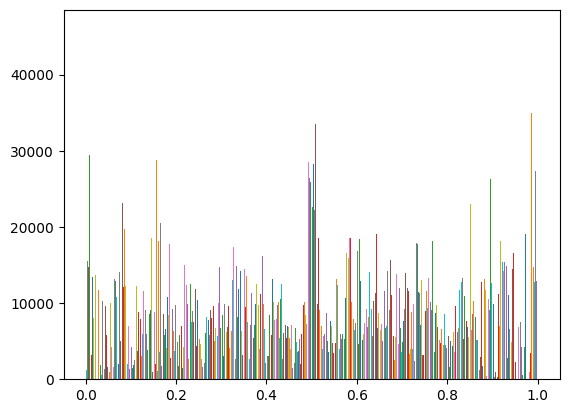

In [151]:
# check the resulting mean pR distribution
pR_collect = []
for i in tqdm(range(100)):
    probR = f_new[f'set_{i}']['probR'][:]
    pR_collect.append(probR.reshape(-1))
_ = plt.hist(pR_collect, bins=100)

Train based on the new balanced dataset

In [ ]:
f